# BLR SVGD Results Visualization

This notebook visualizes the results of SVGD experiments for Bayesian Logistic Regression.

In [1]:
import os
import numpy as np
import pickle
import glob
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics.pairwise import rbf_kernel as rbf
from sklearn.metrics.pairwise import linear_kernel as linear
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-v0_8-colorblind')
import warnings
warnings.filterwarnings('ignore')

In [2]:
def cumulative_mean(dist_list):
    """Compute cumulative mean of a list"""
    if len(dist_list) == 0:
        return np.array([])
    cum_sum = np.cumsum(dist_list, 0)
    for i in range(len(cum_sum)):
        cum_sum[i] /= (i+1)
    return cum_sum

def load_results_from_pickle(results_path, pattern="svgd_results_*.pkl", target_iterations=5000):
    """Load all experiment results from pickle files (指定したiterationのみ)"""
    results = {}
    for filename in glob.glob(os.path.join(results_path, pattern)):
        # 5000iterationのファイルのみ読み込む
        if f"_iter{target_iterations}.pkl" not in filename:
            continue
        with open(filename, 'rb') as f:
            result = pickle.load(f)
        # ファイル名からパラメータ抽出
        filename_parts = os.path.basename(filename).replace('.pkl', '').split('_')
        n_particles = None
        decay_beta = None
        for part in filename_parts:
            if part.startswith('n'):
                n_particles = int(part[1:])
            elif part.startswith('beta'):
                decay_beta = float(part[4:])
        if n_particles is not None and decay_beta is not None:
            key = f"n{n_particles}_beta{decay_beta}"
            results[key] = result
            print(f"Loaded: {filename} -> {key}")
    return results


In [3]:
# Set up paths
path = os.getcwd()
results_path = path + '/results/'

print(f"Results path: {results_path}")
print(f"Results path exists: {os.path.exists(results_path)}")

Results path: /Users/fujisawa/research_code/svgd_convergence/BLR/results/
Results path exists: True


In [4]:
# Load all results
results = load_results_from_pickle(results_path, target_iterations=1000)
print(f"Loaded {len(results)} experiment results")

# Print available experiments
for key in sorted(results.keys()):
    print(f"  {key}")

Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n50_beta0.5_iter1000.pkl -> n50_beta0.5
Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n20_beta0.0_iter1000.pkl -> n20_beta0.0
Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n20_beta1.0_iter1000.pkl -> n20_beta1.0
Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n10_beta0.5_iter1000.pkl -> n10_beta0.5
Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n5_beta0.5_iter1000.pkl -> n5_beta0.5
Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n20_beta0.67_iter1000.pkl -> n20_beta0.67
Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n5_beta1.0_iter1000.pkl -> n5_beta1.0
Loaded: /Users/fujisawa/research_code/svgd_convergence/BLR/results/svgd_results_n5_beta0.67_iter1000.pkl -> n5_beta0.67
Loaded: /Users/fujisawa/research_code/svgd

## Basic Convergence Analysis

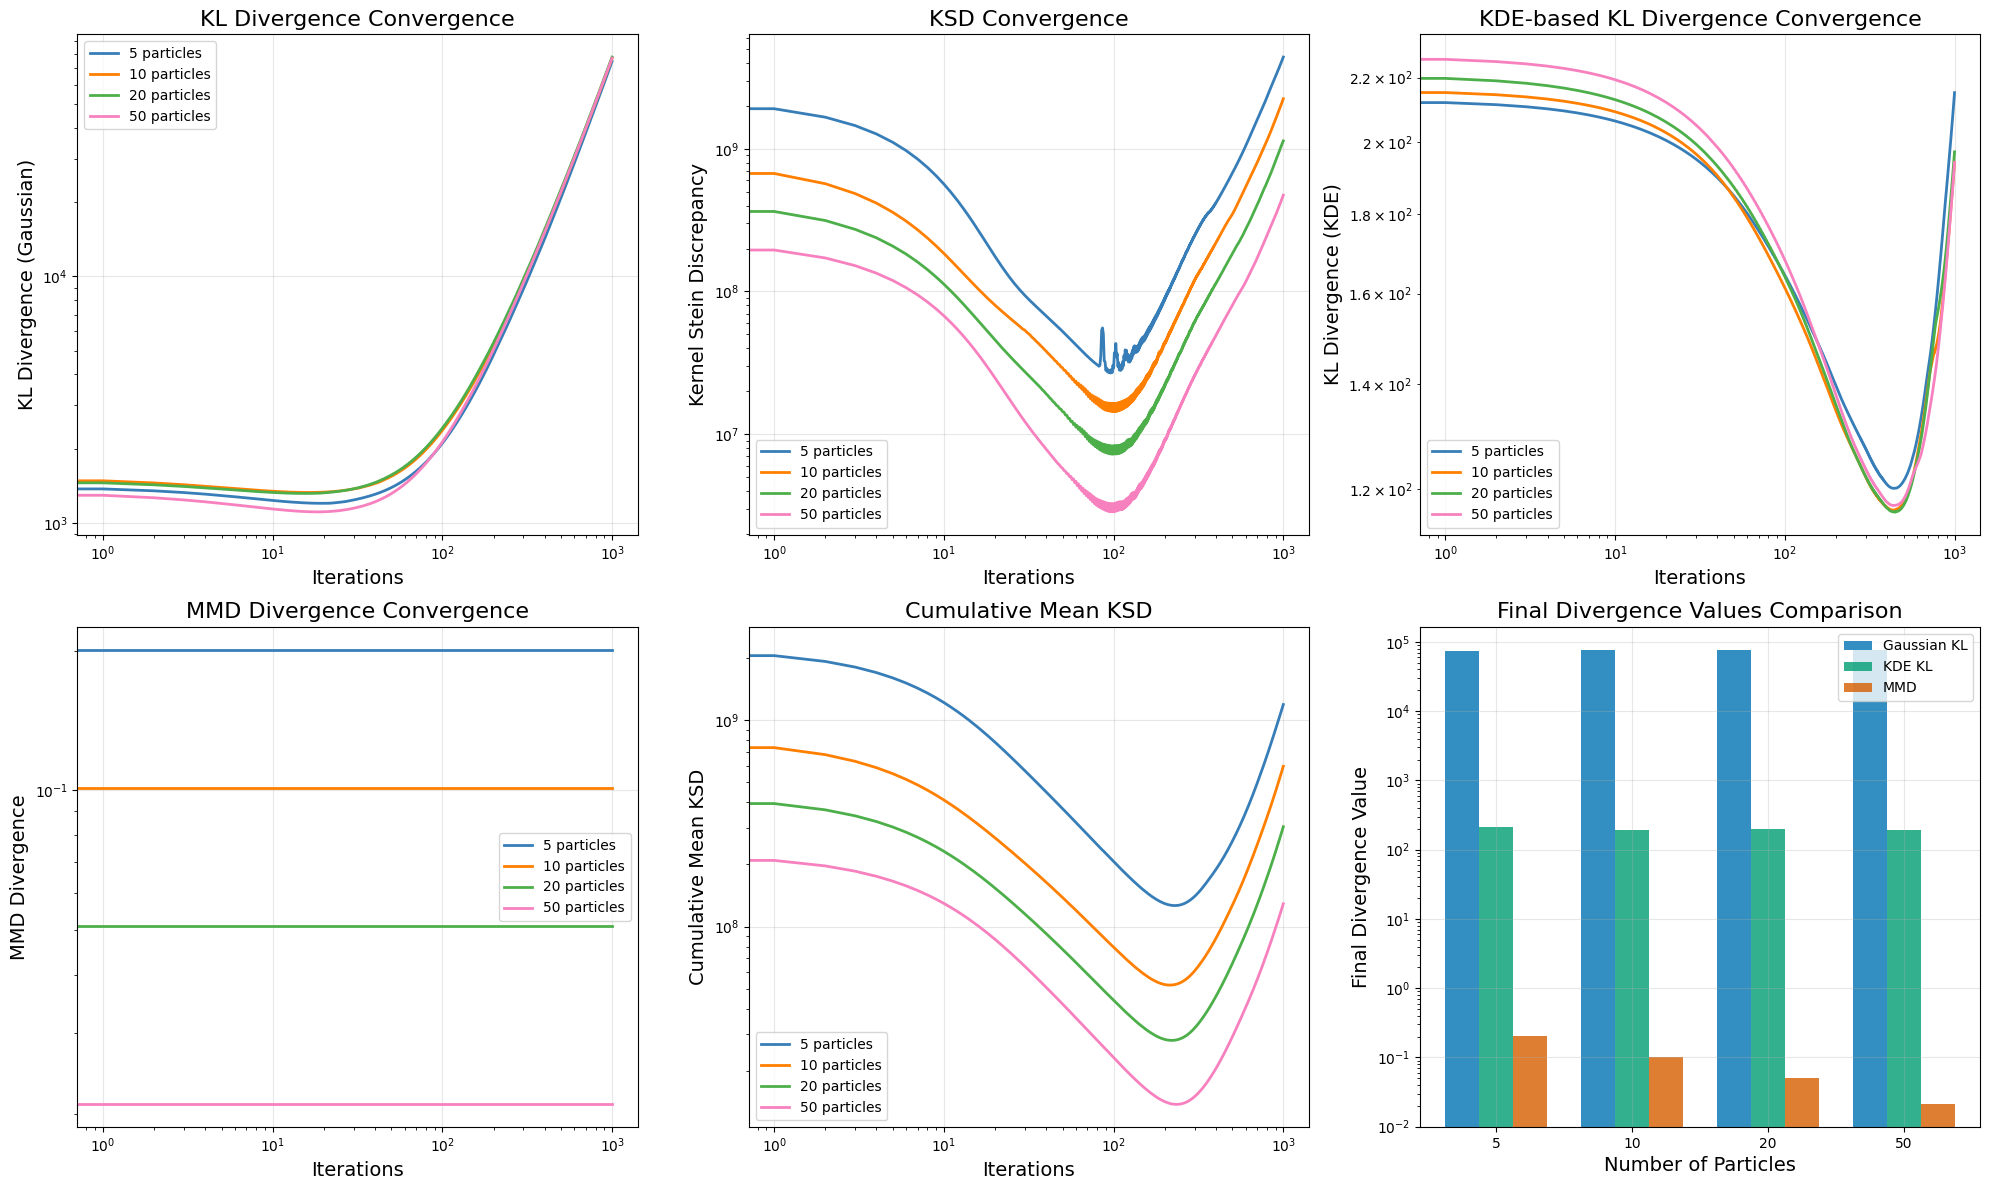

In [12]:
# Plot convergence for different numbers of particles (using beta=0.0 as default)
plt.figure(figsize=(20, 12))

# Colors for different particle counts
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#984ea3']
particle_counts = [5, 10, 20, 50]

# Plot KL divergence convergence
plt.subplot(2, 3, 1)
for i, n_particles in enumerate(particle_counts):
    key = f"n{n_particles}_beta0.0"
    if key in results:
        kl_list = results[key]['kl_list']
        if kl_list is not None and len(kl_list) > 0:
            kl_values = kl_list.flatten()
            plt.plot(kl_values, label=f'{n_particles} particles', 
                    linewidth=2, color=colors[i % len(colors)])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('KL Divergence (Gaussian)', fontsize=14)
plt.title('KL Divergence Convergence', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot KSD convergence
plt.subplot(2, 3, 2)
for i, n_particles in enumerate(particle_counts):
    key = f"n{n_particles}_beta0.0"
    if key in results:
        ksd_list = results[key]['ksd_list']
        if ksd_list is not None and len(ksd_list) > 0:
            ksd_values = ksd_list.flatten()
            plt.plot(ksd_values, label=f'{n_particles} particles', 
                    linewidth=2, color=colors[i % len(colors)])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Kernel Stein Discrepancy', fontsize=14)
plt.title('KSD Convergence', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot KDE-based KL divergence convergence
plt.subplot(2, 3, 3)
for i, n_particles in enumerate(particle_counts):
    key = f"n{n_particles}_beta0.0"
    if key in results:
        kl_kde_list = results[key].get('kl_kde_list', None)
        if kl_kde_list is not None and len(kl_kde_list) > 0:
            valid_indices = ~np.isnan(kl_kde_list.flatten())
            if np.any(valid_indices):
                kl_kde_values = kl_kde_list.flatten()[valid_indices]
                iterations = np.arange(len(kl_kde_list))[valid_indices]
                plt.plot(iterations, kl_kde_values, label=f'{n_particles} particles', 
                        linewidth=2, color=colors[i % len(colors)])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('KL Divergence (KDE)', fontsize=14)
plt.title('KDE-based KL Divergence Convergence', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot MMD divergence convergence
plt.subplot(2, 3, 4)
for i, n_particles in enumerate(particle_counts):
    key = f"n{n_particles}_beta0.0"
    if key in results:
        kl_mmd_list = results[key].get('kl_mmd_list', None)
        if kl_mmd_list is not None and len(kl_mmd_list) > 0:
            valid_indices = ~np.isnan(kl_mmd_list.flatten())
            if np.any(valid_indices):
                kl_mmd_values = kl_mmd_list.flatten()[valid_indices]
                iterations = np.arange(len(kl_mmd_list))[valid_indices]
                plt.plot(iterations, kl_mmd_values, label=f'{n_particles} particles', 
                        linewidth=2, color=colors[i % len(colors)])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('MMD Divergence', fontsize=14)
plt.title('MMD Divergence Convergence', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot cumulative mean KSD
plt.subplot(2, 3, 5)
for i, n_particles in enumerate(particle_counts):
    key = f"n{n_particles}_beta0.0"
    if key in results:
        ksd_list = results[key]['ksd_list']
        if ksd_list is not None and len(ksd_list) > 0:
            ksd_values = ksd_list.flatten()
            cum_ksd = cumulative_mean(ksd_values)
            plt.plot(cum_ksd, label=f'{n_particles} particles', 
                    linewidth=2, color=colors[i % len(colors)])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Cumulative Mean KSD', fontsize=14)
plt.title('Cumulative Mean KSD', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot final values comparison
plt.subplot(2, 3, 6)
final_kl_gaussian = []
final_kl_kde = []
final_mmd = []

for n_particles in particle_counts:
    key = f"n{n_particles}_beta0.0"
    if key in results:
        # Final KL (Gaussian)
        kl_list = results[key]['kl_list']
        if kl_list is not None and len(kl_list) > 0:
            final_kl_gaussian.append(kl_list[-1].item())
        else:
            final_kl_gaussian.append(np.nan)
        
        # Final KDE KL
        kl_kde = results[key].get('kl_kde', None)
        if kl_kde is not None:
            # Convert to scalar if it's a numpy array
            if hasattr(kl_kde, 'item'):
                final_kl_kde.append(kl_kde.item())
            else:
                final_kl_kde.append(float(kl_kde))
        else:
            final_kl_kde.append(np.nan)

        # Final MMD
        kl_mmd = results[key].get('kl_mmd', None)
        if kl_mmd is not None:
            # Convert to scalar if it's a numpy array
            if hasattr(kl_mmd, 'item'):
                final_mmd.append(kl_mmd.item())
            else:
                final_mmd.append(float(kl_mmd))
        else:
            final_mmd.append(np.nan)

x = np.arange(len(particle_counts))
width = 0.25

plt.bar(x - width, final_kl_gaussian, width, label='Gaussian KL', alpha=0.8)
plt.bar(x, final_kl_kde, width, label='KDE KL', alpha=0.8)
plt.bar(x + width, final_mmd, width, label='MMD', alpha=0.8)

plt.xlabel('Number of Particles', fontsize=14)
plt.ylabel('Final Divergence Value', fontsize=14)
plt.title('Final Divergence Values Comparison', fontsize=16)
plt.xticks(x, particle_counts)
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Decay Parameter Sensitivity Analysis

TypeError: only size-1 arrays can be converted to Python scalars

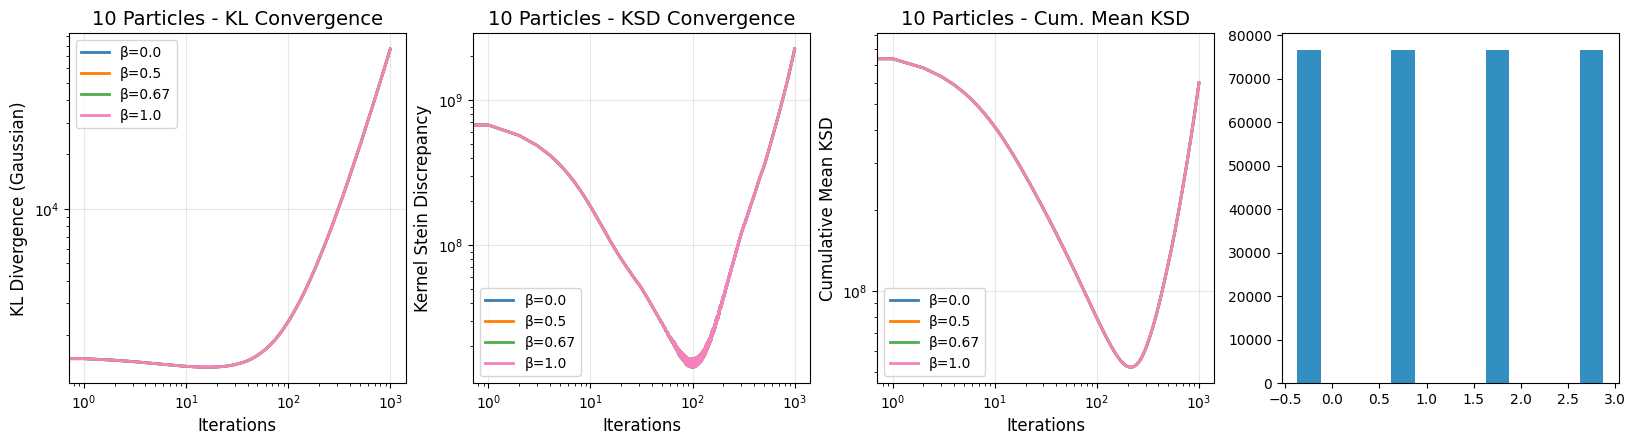

In [25]:
# Analyze sensitivity to decay parameter beta
decay_betas = [0.0, 0.5, 0.67, 1.0]
n_particles = 10  # Focus on 10 particles

plt.figure(figsize=(20, 10))

# Plot KL divergence for different decay parameters
plt.subplot(2, 4, 1)
for i, beta in enumerate(decay_betas):
    key = f"n{n_particles}_beta{beta}"
    if key in results:
        kl_list = results[key]['kl_list']
        if kl_list is not None and len(kl_list) > 0:
            kl_values = kl_list.flatten()
            plt.plot(kl_values, label=f'β={beta}', 
                    linewidth=2, color=colors[i % len(colors)])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('KL Divergence (Gaussian)', fontsize=12)
plt.title(f'{n_particles} Particles - KL Convergence', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot KSD for different decay parameters
plt.subplot(2, 4, 2)
for i, beta in enumerate(decay_betas):
    key = f"n{n_particles}_beta{beta}"
    if key in results:
        ksd_list = results[key]['ksd_list']
        if ksd_list is not None and len(ksd_list) > 0:
            ksd_values = ksd_list.flatten()
            plt.plot(ksd_values, label=f'β={beta}', 
                    linewidth=2, color=colors[i % len(colors)])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Kernel Stein Discrepancy', fontsize=12)
plt.title(f'{n_particles} Particles - KSD Convergence', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot cumulative mean KSD
plt.subplot(2, 4, 3)
for i, beta in enumerate(decay_betas):
    key = f"n{n_particles}_beta{beta}"
    if key in results:
        ksd_list = results[key]['ksd_list']
        if ksd_list is not None and len(ksd_list) > 0:
            ksd_values = ksd_list.flatten()
            cum_ksd = cumulative_mean(ksd_values)
            plt.plot(cum_ksd, label=f'β={beta}', 
                    linewidth=2, color=colors[i % len(colors)])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Cumulative Mean KSD', fontsize=12)
plt.title(f'{n_particles} Particles - Cum. Mean KSD', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot final values comparison
plt.subplot(2, 4, 4)
final_kl_gaussian = []
final_kl_kde = []
final_mmd = []

for beta in decay_betas:
    key = f"n{n_particles}_beta{beta}"
    if key in results:
        # Final KL (Gaussian)
        kl_list = results[key]['kl_list']
        if kl_list is not None and len(kl_list) > 0:
            final_kl_gaussian.append(kl_list[-1].item())
        else:
            final_kl_gaussian.append(np.nan)
        
        # Final KDE KL
        kl_kde = results[key].get('kl_kde', None)
        final_kl_kde.append(kl_kde if kl_kde is not None else np.nan)
        
        # Final MMD
        kl_mmd = results[key].get('kl_mmd', None)
        final_mmd.append(kl_mmd if kl_mmd is not None else np.nan)

x = np.arange(len(decay_betas))
width = 0.25

plt.bar(x - width, final_kl_gaussian, width, label='Gaussian KL', alpha=0.8)
plt.bar(x, final_kl_kde, width, label='KDE KL', alpha=0.8)
plt.bar(x + width, final_mmd, width, label='MMD', alpha=0.8)

plt.xlabel('Decay Parameter β', fontsize=12)
plt.ylabel('Final Divergence Value', fontsize=12)
plt.title(f'{n_particles} Particles - Final Values', fontsize=14)
plt.xticks(x, decay_betas)
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

# Repeat for 20 particles
n_particles = 20

plt.subplot(2, 4, 5)
for i, beta in enumerate(decay_betas):
    key = f"n{n_particles}_beta{beta}"
    if key in results:
        kl_list = results[key]['kl_list']
        if kl_list is not None and len(kl_list) > 0:
            kl_values = kl_list.flatten()
            plt.plot(kl_values, label=f'β={beta}', 
                    linewidth=2, color=colors[i % len(colors)])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('KL Divergence (Gaussian)', fontsize=12)
plt.title(f'{n_particles} Particles - KL Convergence', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 4, 6)
for i, beta in enumerate(decay_betas):
    key = f"n{n_particles}_beta{beta}"
    if key in results:
        ksd_list = results[key]['ksd_list']
        if ksd_list is not None and len(ksd_list) > 0:
            ksd_values = ksd_list.flatten()
            plt.plot(ksd_values, label=f'β={beta}', 
                    linewidth=2, color=colors[i % len(colors)])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Kernel Stein Discrepancy', fontsize=12)
plt.title(f'{n_particles} Particles - KSD Convergence', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 4, 7)
for i, beta in enumerate(decay_betas):
    key = f"n{n_particles}_beta{beta}"
    if key in results:
        ksd_list = results[key]['ksd_list']
        if ksd_list is not None and len(ksd_list) > 0:
            ksd_values = ksd_list.flatten()
            cum_ksd = cumulative_mean(ksd_values)
            plt.plot(cum_ksd, label=f'β={beta}', 
                    linewidth=2, color=colors[i % len(colors)])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Cumulative Mean KSD', fontsize=12)
plt.title(f'{n_particles} Particles - Cum. Mean KSD', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 4, 8)
final_kl_gaussian = []
final_kl_kde = []
final_mmd = []

for beta in decay_betas:
    key = f"n{n_particles}_beta{beta}"
    if key in results:
        # Final KL (Gaussian)
        kl_list = results[key]['kl_list']
        if kl_list is not None and len(kl_list) > 0:
            final_kl_gaussian.append(kl_list[-1].item())
        else:
            final_kl_gaussian.append(np.nan)
        
        # Final KDE KL
        kl_kde = results[key].get('kl_kde', None)
        if kl_kde is not None:
            # Convert to scalar if it's a numpy array
            if hasattr(kl_kde, 'item'):
                final_kl_kde.append(kl_kde.item())
            else:
                final_kl_kde.append(float(kl_kde))
        else:
            final_kl_kde.append(np.nan)

        # Final MMD
        kl_mmd = results[key].get('kl_mmd', None)
        if kl_mmd is not None:
            # Convert to scalar if it's a numpy array
            if hasattr(kl_mmd, 'item'):
                final_mmd.append(kl_mmd.item())
            else:
                final_mmd.append(float(kl_mmd))
        else:
            final_mmd.append(np.nan)

        x = np.arange(len(decay_betas))
        width = 0.25

plt.bar(x - width, final_kl_gaussian, width, label='Gaussian KL', alpha=0.8)
plt.bar(x, final_kl_kde, width, label='KDE KL', alpha=0.8)
plt.bar(x + width, final_mmd, width, label='MMD', alpha=0.8)

plt.xlabel('Decay Parameter β', fontsize=12)
plt.ylabel('Final Divergence Value', fontsize=12)
plt.title(f'{n_particles} Particles - Final Values', fontsize=14)
plt.xticks(x, decay_betas)
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Detailed Analysis of Best Performing Configuration

Best performing configuration: n50_beta0.5
Final KSD: 472979282.334481


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

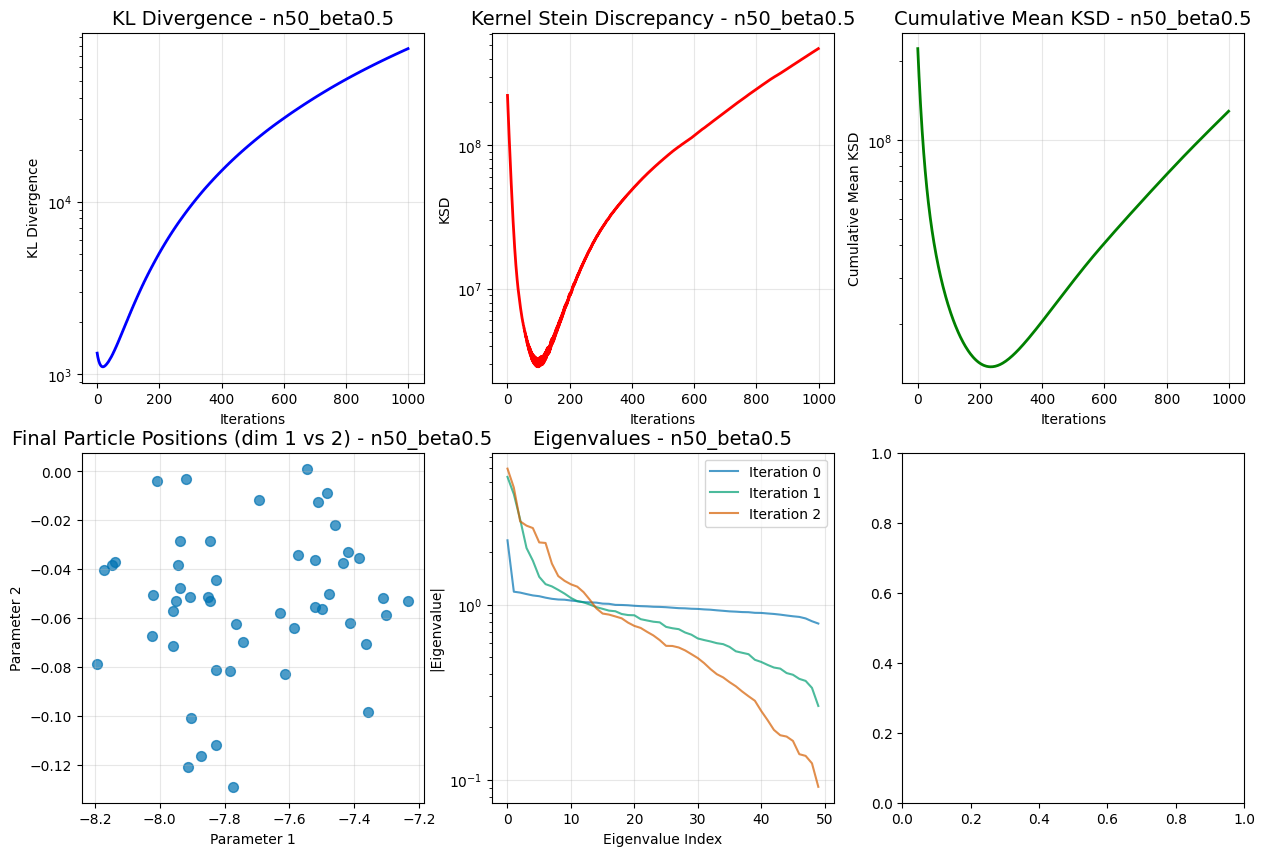

In [8]:
# Find the best performing configuration
best_key = None
best_ksd = float('inf')

for key, result in results.items():
    ksd_list = result['ksd_list']
    if ksd_list is not None and len(ksd_list) > 0:
        final_ksd = ksd_list[-1].item()
        if final_ksd < best_ksd:
            best_ksd = final_ksd
            best_key = key

print(f"Best performing configuration: {best_key}")
print(f"Final KSD: {best_ksd:.6f}")

if best_key is not None:
    best_result = results[best_key]
    
    # Plot detailed convergence
    plt.figure(figsize=(15, 10))
    
    # KL divergence
    plt.subplot(2, 3, 1)
    kl_list = best_result['kl_list']
    if kl_list is not None and len(kl_list) > 0:
        kl_values = kl_list.flatten()
        plt.plot(kl_values, linewidth=2, color='blue')
        plt.title(f'KL Divergence - {best_key}', fontsize=14)
        plt.xlabel('Iterations')
        plt.ylabel('KL Divergence')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
    
    # KSD
    plt.subplot(2, 3, 2)
    ksd_list = best_result['ksd_list']
    if ksd_list is not None and len(ksd_list) > 0:
        ksd_values = ksd_list.flatten()
        plt.plot(ksd_values, linewidth=2, color='red')
        plt.title(f'Kernel Stein Discrepancy - {best_key}', fontsize=14)
        plt.xlabel('Iterations')
        plt.ylabel('KSD')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
    
    # Cumulative mean KSD
    plt.subplot(2, 3, 3)
    if ksd_list is not None and len(ksd_list) > 0:
        cum_ksd = cumulative_mean(ksd_values)
        plt.plot(cum_ksd, linewidth=2, color='green')
        plt.title(f'Cumulative Mean KSD - {best_key}', fontsize=14)
        plt.xlabel('Iterations')
        plt.ylabel('Cumulative Mean KSD')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
    
    # Final particle positions (if available)
    plt.subplot(2, 3, 4)
    theta = best_result.get('theta', None)
    if theta is not None:
        # Plot first two dimensions
        plt.scatter(theta[:, 0], theta[:, 1], alpha=0.7, s=50)
        plt.title(f'Final Particle Positions (dim 1 vs 2) - {best_key}', fontsize=14)
        plt.xlabel('Parameter 1')
        plt.ylabel('Parameter 2')
        plt.grid(True, alpha=0.3)
    
    # Eigenvalues (if available)
    plt.subplot(2, 3, 5)
    eig_list = best_result.get('eig_list', None)
    if eig_list is not None:
        # Plot eigenvalues at different iterations
        for i in range(eig_list.shape[0]):
            eig_vals = np.abs(eig_list[i])
            plt.plot(eig_vals, label=f'Iteration {i}', alpha=0.7)
        plt.title(f'Eigenvalues - {best_key}', fontsize=14)
        plt.xlabel('Eigenvalue Index')
        plt.ylabel('|Eigenvalue|')
        plt.yscale('log')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Summary statistics
    plt.subplot(2, 3, 6)
    metrics = []
    metric_names = []
    
    if kl_list is not None and len(kl_list) > 0:
        metrics.append(kl_list[-1].item())
        metric_names.append('Final KL')
    
    if ksd_list is not None and len(ksd_list) > 0:
        metrics.append(ksd_list[-1].item())
        metric_names.append('Final KSD')
    
    kl_kde = best_result.get('kl_kde', None)
    if kl_kde is not None:
        metrics.append(kl_kde)
        metric_names.append('KDE KL')
    
    kl_mmd = best_result.get('kl_mmd', None)
    if kl_mmd is not None:
        metrics.append(kl_mmd)
        metric_names.append('MMD')
    
    if metrics:
        x = np.arange(len(metrics))
        plt.bar(x, metrics, alpha=0.7)
        plt.title(f'Final Metrics - {best_key}', fontsize=14)
        plt.xticks(x, metric_names, rotation=45)
        plt.ylabel('Value')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Summary Statistics

In [9]:
# Create summary table
print("="*80)
print("SUMMARY OF ALL EXPERIMENTS")
print("="*80)
print(f"{'Configuration':<20} {'Final KL':<12} {'Final KSD':<12} {'KDE KL':<12} {'MMD':<12}")
print("-"*80)

for key in sorted(results.keys()):
    result = results[key]
    
    # Extract values
    final_kl = "N/A"
    final_ksd = "N/A"
    kde_kl = "N/A"
    mmd_val = "N/A"
    
    # Final KL (Gaussian)
    kl_list = result['kl_list']
    if kl_list is not None and len(kl_list) > 0:
        final_kl = f"{kl_list[-1].item():.6f}"
    
    # Final KSD
    ksd_list = result['ksd_list']
    if ksd_list is not None and len(ksd_list) > 0:
        final_ksd = f"{ksd_list[-1].item():.6f}"
    
    # KDE KL
    kl_kde = result.get('kl_kde', None)
    if kl_kde is not None:
        kde_kl = f"{kl_kde:.6f}"
    
    # MMD
    kl_mmd = result.get('kl_mmd', None)
    if kl_mmd is not None:
        mmd_val = f"{kl_mmd:.6f}"
    
    print(f"{key:<20} {final_kl:<12} {final_ksd:<12} {kde_kl:<12} {mmd_val:<12}")

print("="*80)

SUMMARY OF ALL EXPERIMENTS
Configuration        Final KL     Final KSD    KDE KL       MMD         
--------------------------------------------------------------------------------


TypeError: unsupported format string passed to numpy.ndarray.__format__

## Prediction Accuracy Analysis

In [10]:
# Load test data for prediction evaluation
print("Loading test data for prediction evaluation...")
from model import BLR
model = BLR(alpha_prior=1.0, beta_prior=0.1)
X_train, y_train, X_test, y_test = model.load_libsvm_binary_covertype_data(
    n_samples=None, test_size=0.2, random_state=42
)

print(f"Test data shape: {X_test.shape}")
print(f"Test labels: {np.unique(y_test)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# Calculate prediction accuracy for each configuration
print("\n" + "="*80)
print("PREDICTION ACCURACY ANALYSIS")
print("="*80)
print(f"{'Configuration':<20} {'Train Acc':<12} {'Test Acc':<12} {'Particle Count':<15}")
print("-"*80)

accuracies = {}
for key in sorted(results.keys()):
    result = results[key]
    theta = result.get('theta', None)
    
    if theta is not None:
        # Calculate accuracy for each particle
        train_accs = []
        test_accs = []
        
        for i in range(theta.shape[0]):
            # Train accuracy
            train_acc = model.accuracy(theta[i], X_train, y_train)
            train_accs.append(train_acc)
            
            # Test accuracy
            test_acc = model.accuracy(theta[i], X_test, y_test)
            test_accs.append(test_acc)
        
        # Average accuracy across particles
        avg_train_acc = np.mean(train_accs)
        avg_test_acc = np.mean(test_accs)
        
        # Extract particle count from key
        n_particles = int(key.split('_')[0][1:])
        
        accuracies[key] = {
            'train_acc': avg_train_acc,
            'test_acc': avg_test_acc,
            'train_accs': train_accs,
            'test_accs': test_accs,
            'n_particles': n_particles
        }
        
        print(f"{key:<20} {avg_train_acc:.6f}     {avg_test_acc:.6f}     {n_particles:<15}")
    else:
        print(f"{key:<20} {'N/A':<12} {'N/A':<12} {'N/A':<15}")

print("="*80)

Loading test data for prediction evaluation...
Loading libsvm binary UCI Covertype dataset...
Loaded data: 581012 samples, 54 features
Label range: 1.0 to 2.0
Unique labels: [1. 2.]
Mapped labels: [1. 2.] -> [0, 1]
Binary labels: [0 1]
Class distribution: [297711 283301]
Note: Using pre-scaled libsvm data (no additional standardization)
Model initialized: 54 features, 2 classes (binary)
Total parameters: 55 (including global precision)
Data loaded: 464809 training samples, 116203 test samples
Features: 54, Classes: 2
Training class distribution: [238168 226641]
Test class distribution: [59543 56660]
Test data shape: (116203, 54)
Test labels: [0 1]
Test class distribution: [59543 56660]

PREDICTION ACCURACY ANALYSIS
Configuration        Train Acc    Test Acc     Particle Count 
--------------------------------------------------------------------------------
n10_beta0.0          0.755418     0.754985     10             
n10_beta0.5          0.755418     0.754985     10             
n10_b

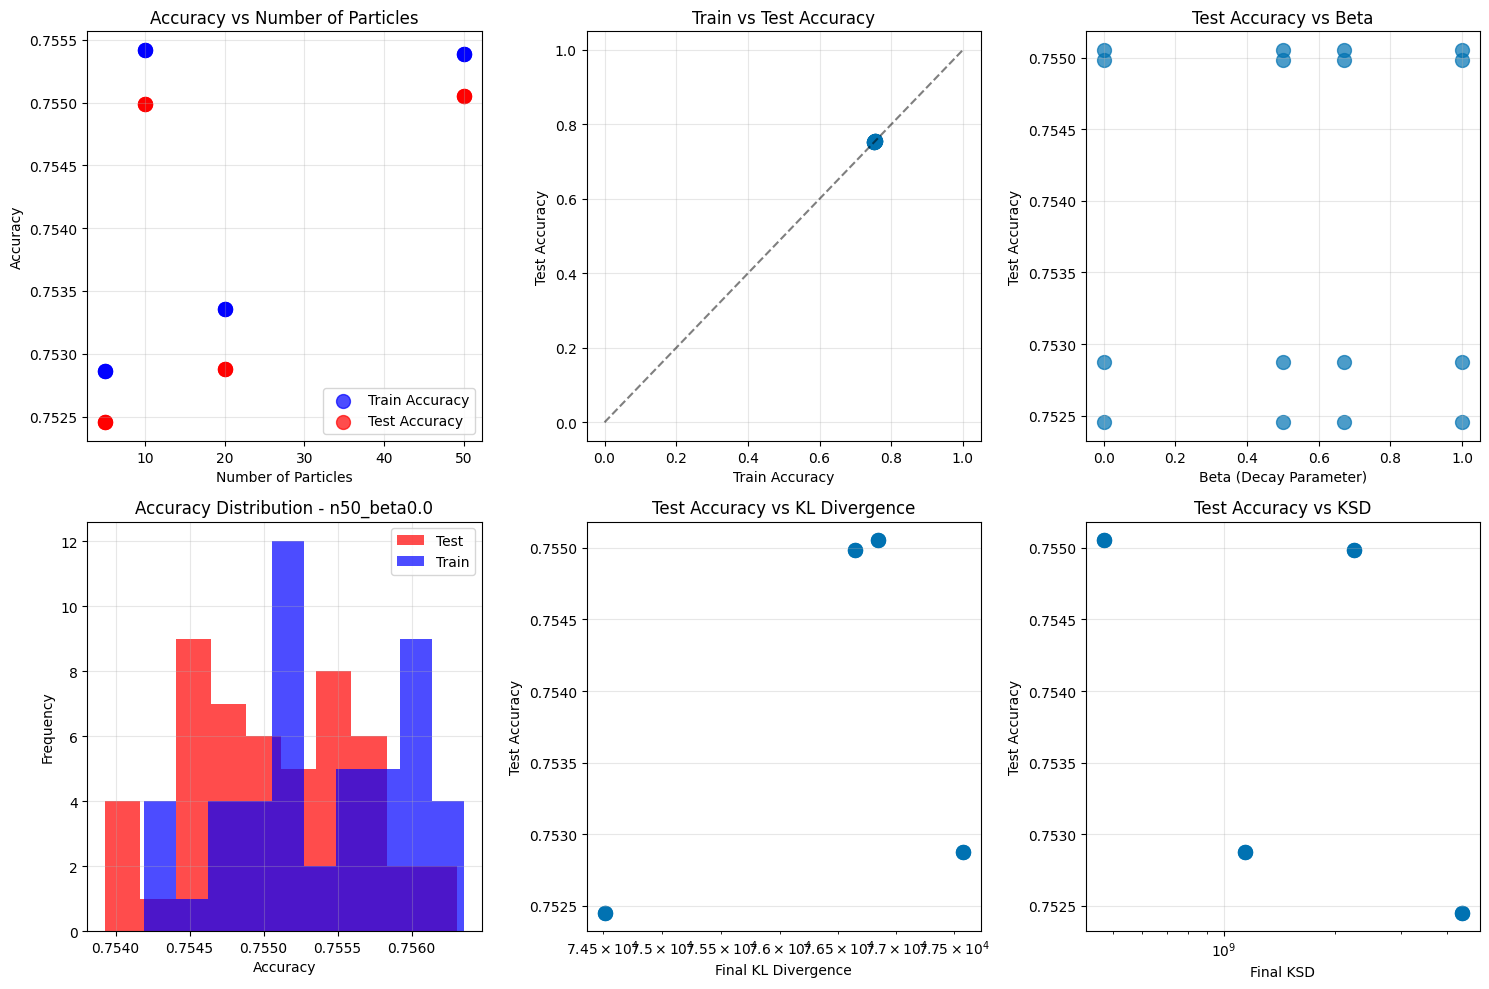


Best performing configuration (by test accuracy): n50_beta0.0
Train Accuracy: 0.755385
Test Accuracy: 0.755053
Number of Particles: 50
Overfitting (Train - Test): 0.000332

Summary Statistics:
Mean Test Accuracy: 0.753842
Std Test Accuracy: 0.001187
Min Test Accuracy: 0.752454
Max Test Accuracy: 0.755053


In [11]:
# Visualize prediction accuracy
if accuracies:
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Accuracy vs Number of Particles
    plt.subplot(2, 3, 1)
    particle_counts = []
    train_accs = []
    test_accs = []
    
    for key in sorted(accuracies.keys()):
        acc_data = accuracies[key]
        particle_counts.append(acc_data['n_particles'])
        train_accs.append(acc_data['train_acc'])
        test_accs.append(acc_data['test_acc'])
    
    plt.scatter(particle_counts, train_accs, s=100, alpha=0.7, label='Train Accuracy', color='blue')
    plt.scatter(particle_counts, test_accs, s=100, alpha=0.7, label='Test Accuracy', color='red')
    plt.xlabel('Number of Particles')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Particles')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Train vs Test Accuracy
    plt.subplot(2, 3, 2)
    plt.scatter(train_accs, test_accs, s=100, alpha=0.7)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # Diagonal line
    plt.xlabel('Train Accuracy')
    plt.ylabel('Test Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Accuracy by Beta (decay parameter)
    plt.subplot(2, 3, 3)
    beta_values = []
    test_accs_by_beta = []
    
    for key in sorted(accuracies.keys()):
        beta = float(key.split('_')[1][4:])  # Extract beta value
        beta_values.append(beta)
        test_accs_by_beta.append(accuracies[key]['test_acc'])
    
    plt.scatter(beta_values, test_accs_by_beta, s=100, alpha=0.7)
    plt.xlabel('Beta (Decay Parameter)')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy vs Beta')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Accuracy Distribution for Best Configuration
    best_key = max(accuracies.keys(), key=lambda k: accuracies[k]['test_acc'])
    best_acc_data = accuracies[best_key]
    
    plt.subplot(2, 3, 4)
    plt.hist(best_acc_data['test_accs'], bins=10, alpha=0.7, color='red', label='Test')
    plt.hist(best_acc_data['train_accs'], bins=10, alpha=0.7, color='blue', label='Train')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.title(f'Accuracy Distribution - {best_key}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Accuracy vs KL Divergence
    plt.subplot(2, 3, 5)
    kl_values = []
    test_accs_for_kl = []
    
    for key in sorted(accuracies.keys()):
        if key in results:
            kl_list = results[key]['kl_list']
            if kl_list is not None and len(kl_list) > 0:
                final_kl = kl_list[-1].item()
                kl_values.append(final_kl)
                test_accs_for_kl.append(accuracies[key]['test_acc'])
    
    if kl_values:
        plt.scatter(kl_values, test_accs_for_kl, s=100, alpha=0.7)
        plt.xlabel('Final KL Divergence')
        plt.ylabel('Test Accuracy')
        plt.title('Test Accuracy vs KL Divergence')
        plt.xscale('log')
        plt.grid(True, alpha=0.3)
    
    # Plot 6: Accuracy vs KSD
    plt.subplot(2, 3, 6)
    ksd_values = []
    test_accs_for_ksd = []
    
    for key in sorted(accuracies.keys()):
        if key in results:
            ksd_list = results[key]['ksd_list']
            if ksd_list is not None and len(ksd_list) > 0:
                final_ksd = ksd_list[-1].item()
                ksd_values.append(final_ksd)
                test_accs_for_ksd.append(accuracies[key]['test_acc'])
    
    if ksd_values:
        plt.scatter(ksd_values, test_accs_for_ksd, s=100, alpha=0.7)
        plt.xlabel('Final KSD')
        plt.ylabel('Test Accuracy')
        plt.title('Test Accuracy vs KSD')
        plt.xscale('log')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print best performing configuration
    print(f"\nBest performing configuration (by test accuracy): {best_key}")
    print(f"Train Accuracy: {best_acc_data['train_acc']:.6f}")
    print(f"Test Accuracy: {best_acc_data['test_acc']:.6f}")
    print(f"Number of Particles: {best_acc_data['n_particles']}")
    
    # Calculate overfitting (difference between train and test accuracy)
    overfitting = best_acc_data['train_acc'] - best_acc_data['test_acc']
    print(f"Overfitting (Train - Test): {overfitting:.6f}")
    
    # Summary statistics
    print(f"\nSummary Statistics:")
    print(f"Mean Test Accuracy: {np.mean(test_accs):.6f}")
    print(f"Std Test Accuracy: {np.std(test_accs):.6f}")
    print(f"Min Test Accuracy: {np.min(test_accs):.6f}")
    print(f"Max Test Accuracy: {np.max(test_accs):.6f}")
else:
    print("No prediction accuracy data available.")